In [69]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

observations = pd.read_csv('observations.csv')
species = pd.read_csv('species_info.csv')

print("observations Columns", observations.columns)
print("species Columns", species.columns)
print("observations", observations.head(10))
print("species", species.head(10))
print(f"number of species:{species.scientific_name.nunique()}")
print(f"number of categories:{species.category.nunique()}")
print(f"categories:{species.category.unique()}")
print(f"number of conservation statuses:{species.conservation_status.nunique()}")
print(f"unique  conservation statuses:{species.conservation_status.unique()}")
print(f"number of parks:{observations.park_name.nunique()}")
print(f"unique parks:{observations.park_name.unique()}")
species.fillna('no intervention', inplace=True)
species.groupby("conservation_status").size()

maxRows = species['scientific_name'].count()
print('% Missing Data:')
print((1 - species.count() / maxRows) * 100)

conservationCategory = species[species.conservation_status != 'no intervention']\
    .groupby(["conservation_status", "category"])['scientific_name']\
        .nunique()\
            .unstack()
            
print(conservationCategory)
            

observations Columns Index(['scientific_name', 'park_name', 'observations'], dtype='object')
species Columns Index(['category', 'scientific_name', 'common_names', 'conservation_status'], dtype='object')
observations                      scientific_name                            park_name  \
0                 Vicia benghalensis  Great Smoky Mountains National Park   
1                     Neovison vison  Great Smoky Mountains National Park   
2                  Prunus subcordata               Yosemite National Park   
3               Abutilon theophrasti                  Bryce National Park   
4           Githopsis specularioides  Great Smoky Mountains National Park   
5  Elymus virginicus var. virginicus               Yosemite National Park   
6                   Spizella pusilla            Yellowstone National Park   
7                  Elymus multisetus  Great Smoky Mountains National Park   
8             Lysimachia quadrifolia               Yosemite National Park   
9         Diph

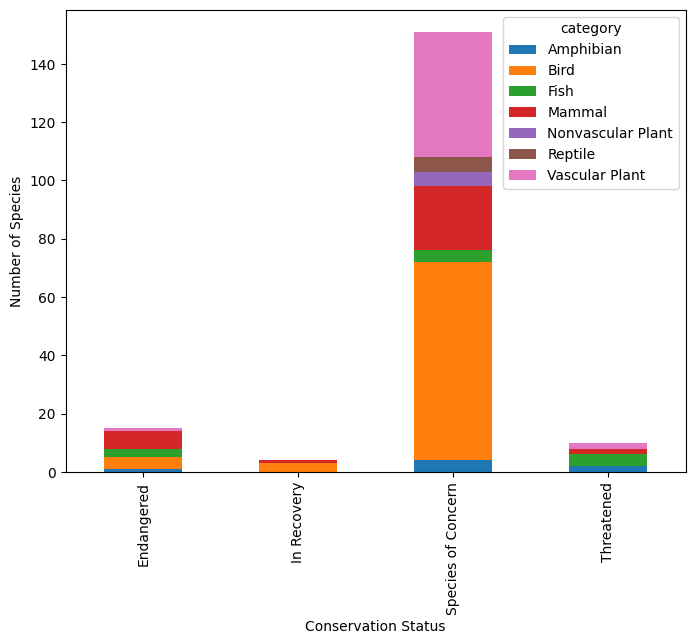

In [70]:

ax = conservationCategory.plot(kind = 'bar', figsize=(8,6), stacked=True)
ax.set_xlabel("Conservation Status")
ax.set_ylabel("Number of Species");

In [71]:
species['is_protected'] = species.conservation_status != 'no intervention'

category_counts = species.groupby(['category', 'is_protected'])\
    .scientific_name.nunique().reset_index()\
        .pivot(columns= 'is_protected', index= 'category', values= 'scientific_name')\
            .reset_index().rename(columns={False: 'not_protected', True: 'protected'})
            
category_counts.columns = ['category', 'not_protected', 'protected']

